#Download necessary libraries

In [3]:
!pip install vadersentiment
!pip install lxml
!pip install beautifulsoup4

     |████████████████████████████████| 133kB 4.9MB/s 


#Scrape Tweets and get Sentiment Scores

Gathered 846 Tweets
Ratio of tweets containing the phrase 'Fake': 0.06382978723404255


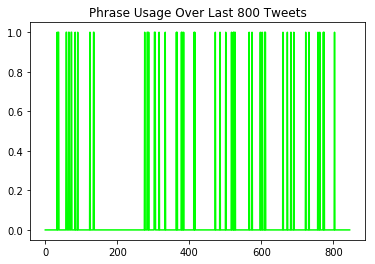

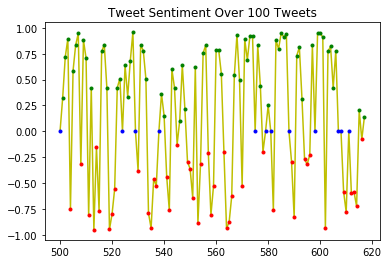

In [74]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import bs4 as bs
import urllib.request
import requests
import json
import numpy as np
from datetime import datetime
from bs4 import BeautifulSoup

twitter_handle = 'realDonaldTrump'

analyser = SentimentIntensityAnalyzer()

source = urllib.request.urlopen('https://twitter.com/' + twitter_handle).read()
soup = bs.BeautifulSoup(source,'lxml')
tweets = soup.findAll('p','tweet-text')
time_stamps = soup.findAll('span','_timestamp')

#################################
#Get Tweets on following pages
###################################
next_pointer = soup.find("div", {"class": "stream-container"})["data-min-position"]
count = 0
while count < 100:
  count +=1
  next_url = "https://twitter.com/i/profiles/show/" + twitter_handle + \
              "/timeline/tweets?include_available_features=1&" \
              "include_entities=1&max_position=" + next_pointer + "&reset_error_state=false"

  next_response = None
  try:
      next_response = requests.get(next_url)
  except Exception as e:
      # in case there is some issue with request. None encountered so far.
      print(e)

  tweets_data = next_response.text
  tweets_obj = json.loads(tweets_data)
  if not tweets_obj["has_more_items"] and not tweets_obj["min_position"]:
      # using two checks here bcz in one case has_more_items was false but there were more items
      break
  next_pointer = tweets_obj["min_position"]

  html = tweets_obj["items_html"]
  soup = BeautifulSoup(html, 'lxml')
  tweets.extend(soup.findAll('p','tweet-text'))
  time_stamps.extend(soup.findAll('span','_timestamp'))
print("Gathered {} Tweets".format(len(tweets)))

##########################
#Graph sentiment of tweets
##########################
def getSentiment(tweets):
  xs = []
  ys = []
  for t in range(len(tweets)):
    if not 'pic.twitter.com' in tweets[t].text:
      xs.append(len(xs))
      score = analyser.polarity_scores(tweets[t].text)
      ys.append(score['compound'])
  ys = ys[::-1]
  return xs,ys

def countPhrase(tweets, phrase):
  ys = np.zeros(len(tweets))
  for t in range(len(tweets)):
    if phrase in tweets[t].text:
      ys[t]=1
  ratio = np.sum(ys)/ys.shape[0]
  return ys,ratio


#Look for usage of a specific phrase overtime
phrase = 'Fake'

xs = np.arange(len(tweets))
ys,ratio = countPhrase(tweets,phrase)
print("Ratio of tweets containing the phrase '{}': {}".format(phrase,ratio))
plt.plot(xs,ys,'-',color='#00ff00')
plt.title("Phrase Usage Over Last 800 Tweets")
plt.show()


#Look at the the  sentiment of tweets over time
print('\n\n\n')
xs,ys = getSentiment(tweets)

xs = np.array(xs[500:])
ys = np.array(ys[500:])

pos = np.argwhere(ys>0)
negs = np.argwhere(ys<0)
zeros = np.argwhere(ys==0)

plt.plot(xs,ys,'y-')
plt.plot(xs[negs],ys[negs],'r.')
plt.plot(xs[pos],ys[pos],'g.')
plt.plot(xs[zeros],ys[zeros],'b.')
plt.title('Tweet Sentiment Over 100 Tweets')
plt.show()